# Initialization

In [1]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using GPU')
else:
    device = 'cpu'
    print('Using CPU')

Using GPU


In [2]:
import sys, os
sys.path.append("/global/homes/b/bwood/machine_learning/open_catalyst_project/baselines")

In [3]:
from baselines.modules.normalizer import Normalizer
from baselines.models.cgcnn import CGCNN
from baselines.datasets.base import BaseDataset
from train_hpo import train, validate

In [4]:
#import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch_geometric.nn import GCNConv, SAGEConv
from torch.optim.lr_scheduler import MultiStepLR

In [5]:
train_size = 2560
val_size = 640
test_size = 800

In [6]:
no_remain_batch_size = []
for i in range(1, 120):
    if float(train_size) % i == 0:
        no_remain_batch_size.append(i)

In [7]:
no_remain_batch_size

[1, 2, 4, 5, 8, 10, 16, 20, 32, 40, 64, 80]

# Load data and define normalizer

In [8]:
data_config = {"src": "/global/homes/b/bwood/machine_learning/ulissi_cnn/hpo/ocp_cgcnn/cgcnn/hpo/data_voronoi_H_4k_surface", 
               "train_size": 2560, 
               "val_size": 640, 
               "test_size": 800}

In [9]:
h_dataset = BaseDataset(config=data_config)
train_loader, val_loader, test_loader = h_dataset.get_dataloaders(batch_size=80)

In [10]:
# Compute mean, std of training set labels.
normalizer = Normalizer(train_loader.dataset.data.y, device)

# Build model

In [11]:
# Build model
model = CGCNN(num_atoms=train_loader.dataset.data.x.shape[-1], 
              bond_feat_dim=train_loader.dataset.data.edge_attr.shape[-1], 
              num_targets=1, 
              atom_embedding_size=46, 
              num_graph_conv_layers=8, 
              fc_feat_size=83, 
              num_fc_layers=4).to(device)

criterion = nn.L1Loss()
optimizer = optim.AdamW(model.parameters(), lr = 0.0056)
scheduler = MultiStepLR(optimizer, milestones=[100], gamma=0.1)

# Run model

In [12]:
epochs = 150

In [13]:
t_loss = [] 
t_mae = []
v_loss = []
v_mae = []
for epoch in range(1, epochs + 1):
        t_loss_i, t_mae_i = train(model, criterion, optimizer, train_loader, normalizer, device)
        v_loss_i, v_mae_i = validate(model, criterion, optimizer, val_loader, normalizer, device, mae_print=True)
        t_loss.append(t_loss_i)
        t_mae.append(t_mae_i)
        v_loss.append(v_loss_i)
        v_mae.append(v_mae_i)
        scheduler.step()

 * MAE 0.322
 * MAE 0.317
 * MAE 0.324
 * MAE 0.305
 * MAE 0.286
 * MAE 0.310
 * MAE 0.289
 * MAE 0.276
 * MAE 0.293
 * MAE 0.270
 * MAE 0.267
 * MAE 0.280
 * MAE 0.267
 * MAE 0.261
 * MAE 0.273
 * MAE 0.274
 * MAE 0.272
 * MAE 0.258
 * MAE 0.255
 * MAE 0.256
 * MAE 0.282
 * MAE 0.277
 * MAE 0.252
 * MAE 0.258
 * MAE 0.257
 * MAE 0.267
 * MAE 0.259
 * MAE 0.246
 * MAE 0.272
 * MAE 0.252
 * MAE 0.249
 * MAE 0.251
 * MAE 0.252
 * MAE 0.248
 * MAE 0.239
 * MAE 0.266
 * MAE 0.242
 * MAE 0.247
 * MAE 0.248
 * MAE 0.251
 * MAE 0.246
 * MAE 0.240
 * MAE 0.238
 * MAE 0.243
 * MAE 0.264
 * MAE 0.252
 * MAE 0.236
 * MAE 0.244
 * MAE 0.259
 * MAE 0.264
 * MAE 0.266
 * MAE 0.245
 * MAE 0.254
 * MAE 0.263
 * MAE 0.257
 * MAE 0.268
 * MAE 0.246
 * MAE 0.259
 * MAE 0.262
 * MAE 0.244
 * MAE 0.246
 * MAE 0.250
 * MAE 0.276
 * MAE 0.263
 * MAE 0.249
 * MAE 0.255
 * MAE 0.248
 * MAE 0.263
 * MAE 0.248
 * MAE 0.254
 * MAE 0.277
 * MAE 0.259
 * MAE 0.246
 * MAE 0.253
 * MAE 0.252
 * MAE 0.247
 * MAE 0.246

In [14]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

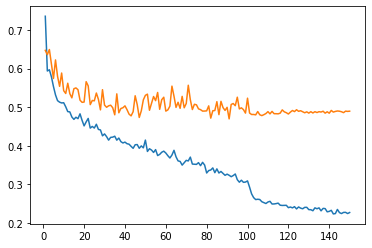

In [15]:
plt.plot(range(1,151), t_loss, range(1, 151), v_loss)

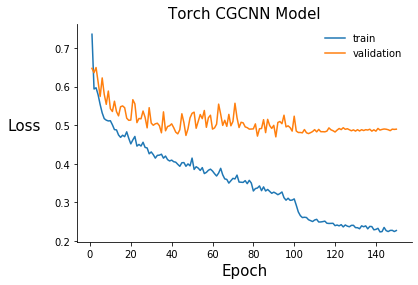

In [17]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(range(1,151), t_loss, range(1,151), v_loss)
#ax.plot(angles, list_kbt, '--')
ax.set_xlabel('Epoch', fontsize=15)
ax.set_ylabel('Loss', rotation=0, labelpad=30, fontsize=15)
#ax.set_ylim(0.00, 0.14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title('Torch CGCNN Model', fontsize=15)
ax.legend(['train', 'validation'], frameon=False)